,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,1,0,0,0,0
1,38,17076.0,40.0,0,NaN,72.0,2.0,0.0,CS-12 E,1985-02-15 11:48:22,...,NaN,NaN,10,records100/00000/00038_lr,records500/00000/00038_hr,1,0,0,0,0
2,40,19501.0,60.0,0,NaN,85.0,2.0,0.0,CS-12 E,1985-02-20 11:43:45,...,NaN,NaN,10,records100/00000/00040_lr,records500/00000/00040_hr,1,0,0,0,0
3,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,1,0,0,0,0
4,59,19475.0,54.0,0,NaN,67.0,2.0,0.0,CS-12 E,1985-06-12 06:36:01,...,NaN,NaN,10,records100/00000/00059_lr,records500/00000/00059_hr,1,0,0,0,0


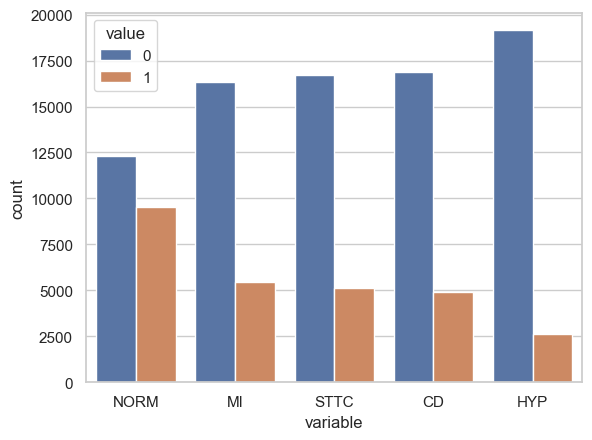

In [1]:
from torch.utils.data import DataLoader
from ver5_journal.common.data.ECG_Data import ECG_Data
from ver5_journal.common.data.create_final_data import create_final_data

final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)
ECG_val = final_data[final_data['strat_fold'] == 9].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=False)

val_dataset=ECG_Data(ECG_val)
val_loader=DataLoader(test_dataset,batch_size=32, shuffle=False)

ECG_test.head()

In [8]:
from ver5_journal.common.BCRnetwork.BCResNets import BCResNets
import torch

# 모델 순서 정의
sequence = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장

model_path = f'../common/one_stage_models/one_stage_BCR_model.pth'
model = BCResNets(int(2 * 8), 5, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
# model.load_state_dict(torch.load(model_path, weights_only=True))
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()
# 모델의 전체 파라미터 수를 계산
param = sum(p.numel() for p in model.parameters())

# 모델의 전체 파라미터 수를 계산
print(f"total param: {param}")

total param: 28029


In [10]:
from torch import nn
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np
import torch

# 모델에서 사용할 최적 임계값을 저장할 리스트 (각 클래스별)
optimal_thresholds = []
loss_fn = nn.BCEWithLogitsLoss()

# Multi-label classifier에 맞게 데이터 예측
y_true_all = []
y_scores_all = []

# val 데이터셋에서 예측 결과 저장
with torch.no_grad():
    for data, labels in val_loader:
        data, labels = data.to(device), labels.to(device)
        
        data = data.float()  # float32 타입으로 변환
        data = data.squeeze(1)  # 4D 데이터를 3D로 변환 (batch_size, 1, sequence_length, features)

        # 모델의 출력을 얻음
        outputs = model(data)

        # 시그모이드를 사용해 각 클래스에 대해 확률값을 계산
        preds = torch.sigmoid(outputs).cpu().numpy()

        # 스코어와 실제값을 각각 저장 (배치 내 모든 샘플에 대해 처리)
        y_scores_all.extend(preds)  # 확률 값 저장
        y_true_all.extend(labels.cpu().numpy())     # 실제 라벨 저장

# numpy 배열로 변환
y_true_all = np.array(y_true_all)
y_scores_all = np.array(y_scores_all)

# 각 클래스에 대해 ROC 커브 및 최적 임계값 계산
num_classes = y_true_all.shape[1]

for idx in range(num_classes):
    y_true = y_true_all[:, idx]  # 해당 클래스의 실제 라벨
    y_scores = y_scores_all[:, idx]  # 해당 클래스의 예측 스코어

    # ROC 커브 계산
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Youden's J 통계량 계산 (TPR - FPR)
    youdens_j = tpr - fpr

    # Youden's J가 최대인 임계값 찾기
    optimal_idx = np.argmax(youdens_j)
    optimal_threshold = thresholds[optimal_idx]
    optimal_thresholds.append(optimal_threshold)  # 최적 임계값 저장

    # AUC 계산
    auc_value = auc(fpr, tpr)

    print(f'Class {idx} - AUC: {auc_value:.4f}')
    print(f'Optimal threshold for class {idx} using Youden\'s J: {optimal_threshold:.4f}')

    # ROC 커브 시각화 (필요시 주석 해제)
    # plt.figure()
    # plt.plot(fpr, tpr, label=f'AUC (Class {idx}) = {auc_value:.4f}')
    # plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve for Class {idx}')
    # plt.legend(loc="lower right")
    # plt.show()

Class 0 - AUC: 0.9323
Optimal threshold for class 0 using Youden's J: 0.2636
Class 1 - AUC: 0.9162
Optimal threshold for class 1 using Youden's J: 0.3011
Class 2 - AUC: 0.9208
Optimal threshold for class 2 using Youden's J: 0.2423
Class 3 - AUC: 0.9172
Optimal threshold for class 3 using Youden's J: 0.2984
Class 4 - AUC: 0.8465
Optimal threshold for class 4 using Youden's J: 0.0327


### TEST: 각 분류기의 개별 지표(classification_report) 및 통합 지표(Hamming Loss) 시각화

In [11]:
import torch

# 테스트 셋으로 재입력
y_true_all = []
y_scores_all = []

# 테스트 데이터셋에서 예측 결과 저장
with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        data = data.float()  # float32 타입으로 변환
        data = data.squeeze(1)  # 4D 데이터를 3D로 변환 (batch_size, 1, sequence_length, features)

        # 모델의 출력을 얻음
        outputs = model(data)

        # 시그모이드를 사용해 각 클래스에 대해 확률값을 계산
        preds = torch.sigmoid(outputs).cpu().numpy()

        # 스코어와 실제값을 각각 저장 (배치 내 모든 샘플에 대해 처리)
        y_scores_all.extend(preds)  # 확률 값 저장
        y_true_all.extend(labels.cpu().numpy())     # 실제 라벨 저장

# numpy 배열로 변환
y_true_all = np.array(y_true_all)
y_scores_all = np.array(y_scores_all)

Class 0 - AUC: 0.9323
Classification Report for Class NORM:
              precision    recall  f1-score   support

         0.0       0.93      0.81      0.86      1235
         1.0       0.79      0.92      0.85       963

    accuracy                           0.86      2198
   macro avg       0.86      0.86      0.86      2198
weighted avg       0.87      0.86      0.86      2198

Class 1 - AUC: 0.9162
Classification Report for Class MI:
              precision    recall  f1-score   support

         0.0       0.95      0.80      0.87      1648
         1.0       0.59      0.88      0.71       550

    accuracy                           0.82      2198
   macro avg       0.77      0.84      0.79      2198
weighted avg       0.86      0.82      0.83      2198

Class 2 - AUC: 0.9208
Classification Report for Class STTC:
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1692
         1.0       0.63      0.86      0.73       506

    

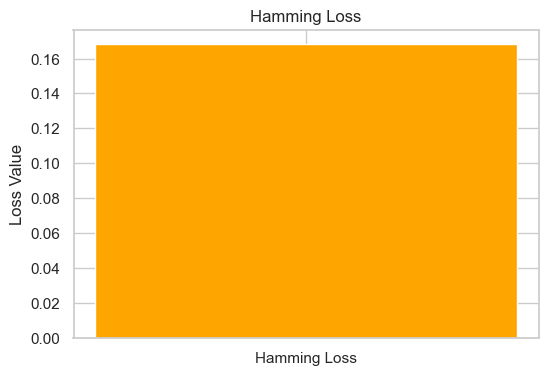

In [12]:
import numpy as np
from sklearn.metrics import classification_report, hamming_loss, roc_auc_score

# 최적 임계값을 사용한 예측 이진화
y_pred_all = np.zeros_like(y_scores_all)
auc_values=[]
# 클래스별 AUC 및 최적 임계값 적용
for idx in range(num_classes):
    y_true = y_true_all[:, idx]
    y_scores = y_scores_all[:, idx]

    # AUC 계산
    auc_value = roc_auc_score(y_true, y_scores)
    auc_values.append(auc_value)
    print(f'Class {idx} - AUC: {auc_value:.4f}')

    # 예측 이진화
    y_pred_all[:, idx] = (y_scores >= optimal_thresholds[idx]).astype(int)
    
    # 각 클래스별 classification_report 출력
    class_report = classification_report(y_true, y_pred_all[:, idx], zero_division=0)
    print(f'Classification Report for Class {sequence[idx]}:\n{class_report}')

# Macro AUC 계산 (각 클래스 AUC 값의 평균)
macro_auc = np.mean(auc_values)
print(f'Macro AUC: {macro_auc:.4f}')

# 통합 지표: Hamming Loss 계산
hamming_loss_value = hamming_loss(y_true_all, y_pred_all)
print(f'Hamming Loss: {hamming_loss_value:.4f}')

# Hamming Loss 시각화
plt.figure(figsize=(6, 4))
plt.bar(['Hamming Loss'], [hamming_loss_value], color='orange')
plt.title('Hamming Loss')
plt.ylabel('Loss Value')
plt.show()